In [1]:
%matplotlib notebook

from rlsm.datasets import load_consulting
from rlsm import ReciprocityLSM

In [2]:
Y, locations = load_consulting()

In [3]:
model = ReciprocityLSM(n_features=2, reciprocity_type='distance', random_state=142)
model.sample(Y, n_warmup=2500, n_samples=5000)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7500/7500 [17:34<00:00,  7.11it/s, 127 steps of size 4.03e-02. acc. prob=0.86]


In [4]:
model.print_summary()

AUC: 0.970, AIC: 2532.482, WAIC: 2394.557

                  mean       std    median      2.5%     97.5%     n_eff     r_hat
   dist_coef      0.43      0.08      0.44      0.29      0.58   4119.77      1.00
       r_var      0.71      0.18      0.69      0.39      1.08   2374.73      1.00
  recip_coef      0.50      0.36      0.50     -0.21      1.19   4062.40      1.00
       s_var      2.24      0.49      2.18      1.36      3.24   1825.72      1.00
     sr_corr     -0.16      0.18     -0.16     -0.51      0.21   2020.00      1.00
       z_var     15.11      2.40     14.86     10.70     19.95   2081.29      1.00

Number of divergences: 131


In [31]:
import joblib

joblib.dump(model, open('consult_dis.pkl', 'wb'))

<IPython.core.display.Javascript object>


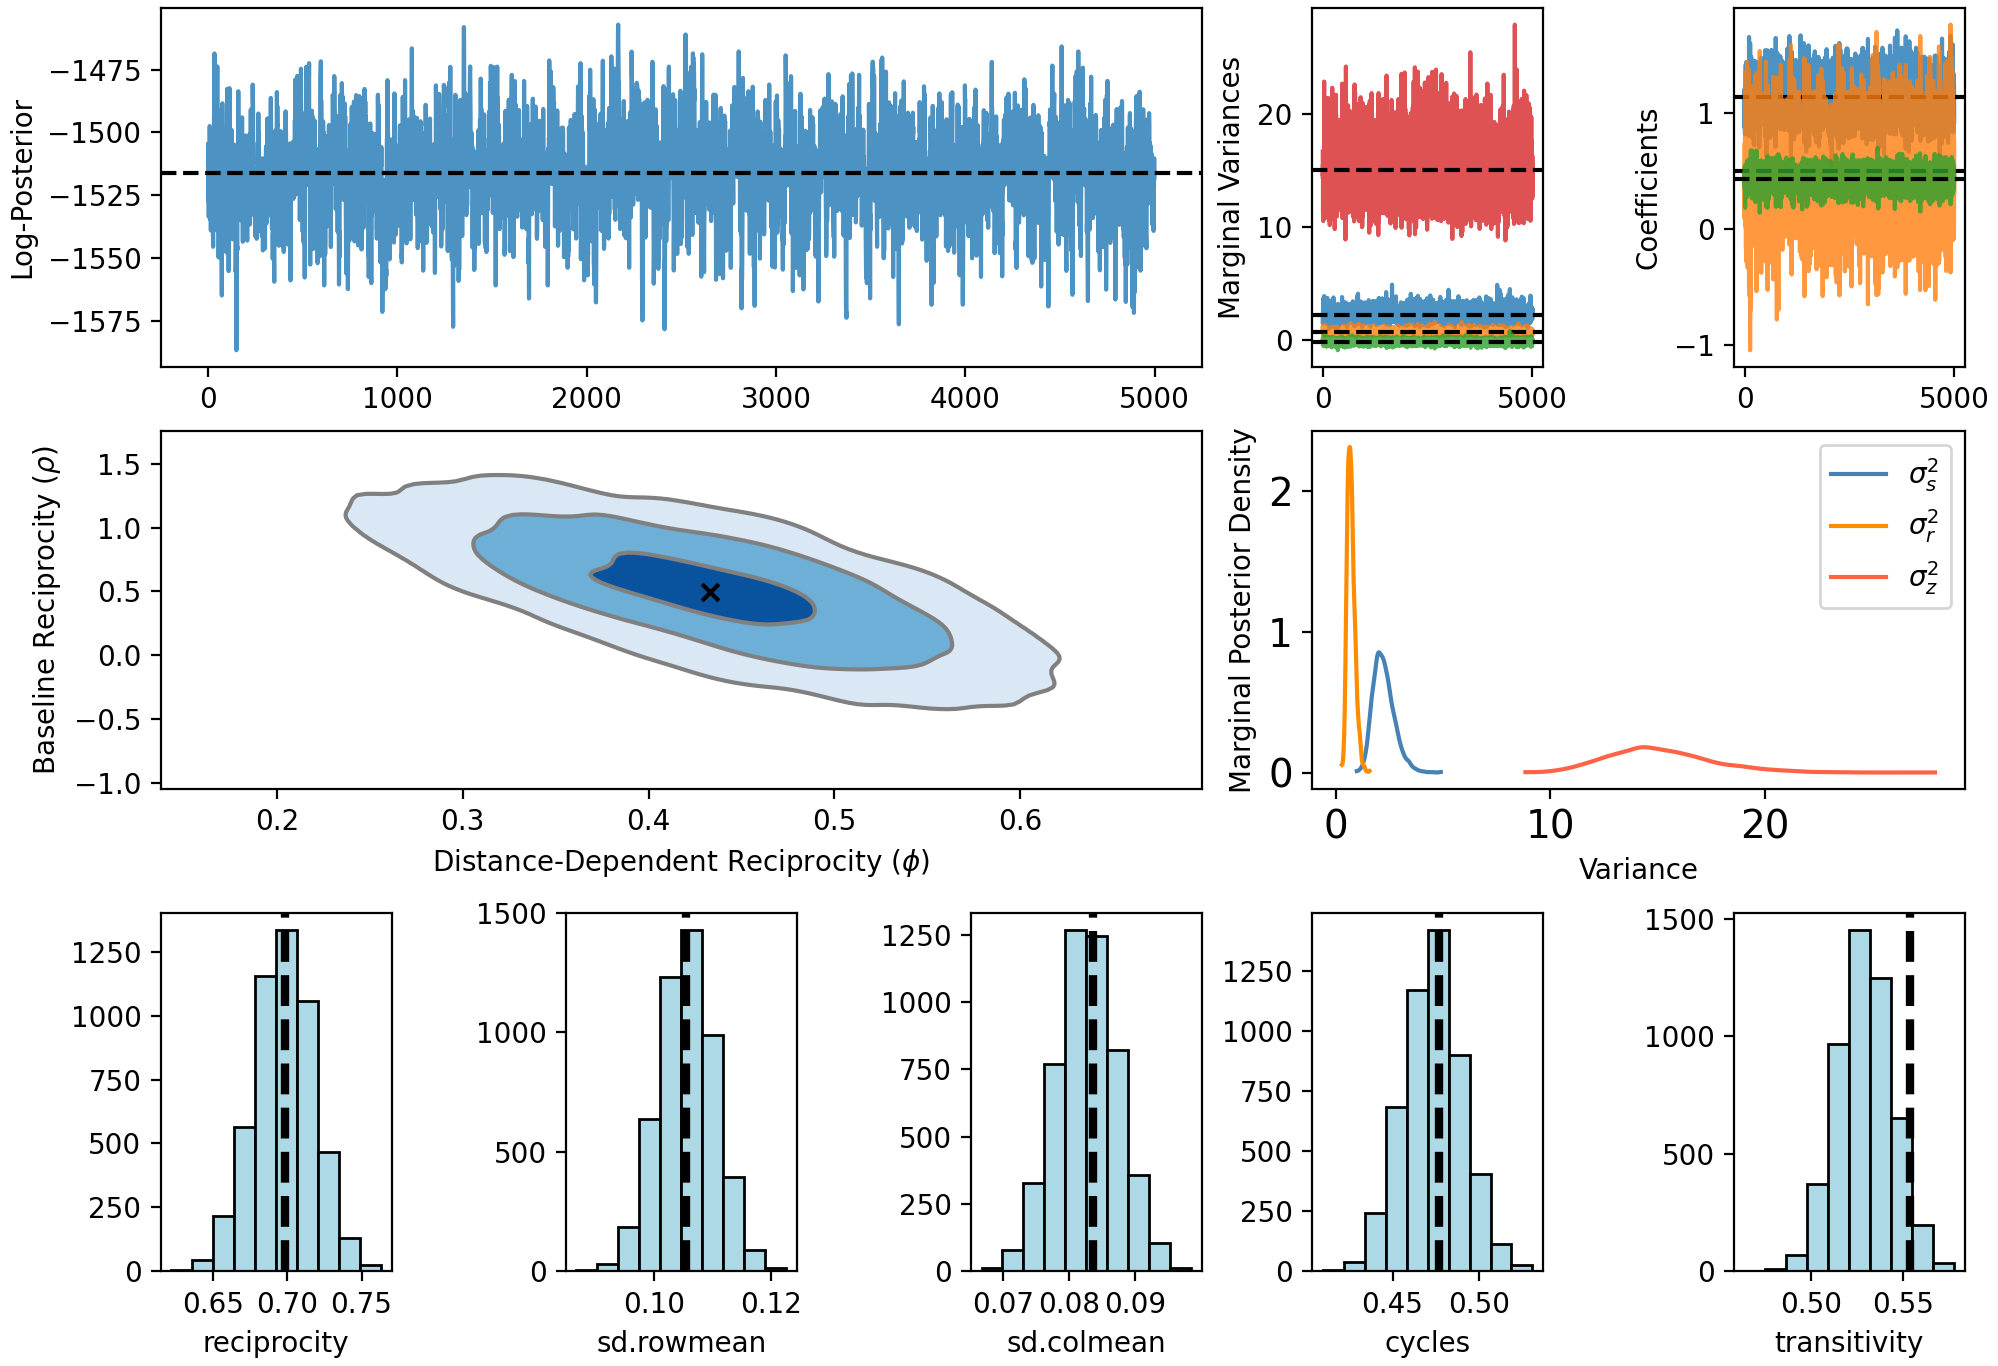

In [5]:
model.plot();

In [3]:
import joblib

model_dis = joblib.load(open('consult_dis.pkl', 'rb'))

<IPython.core.display.Javascript object>


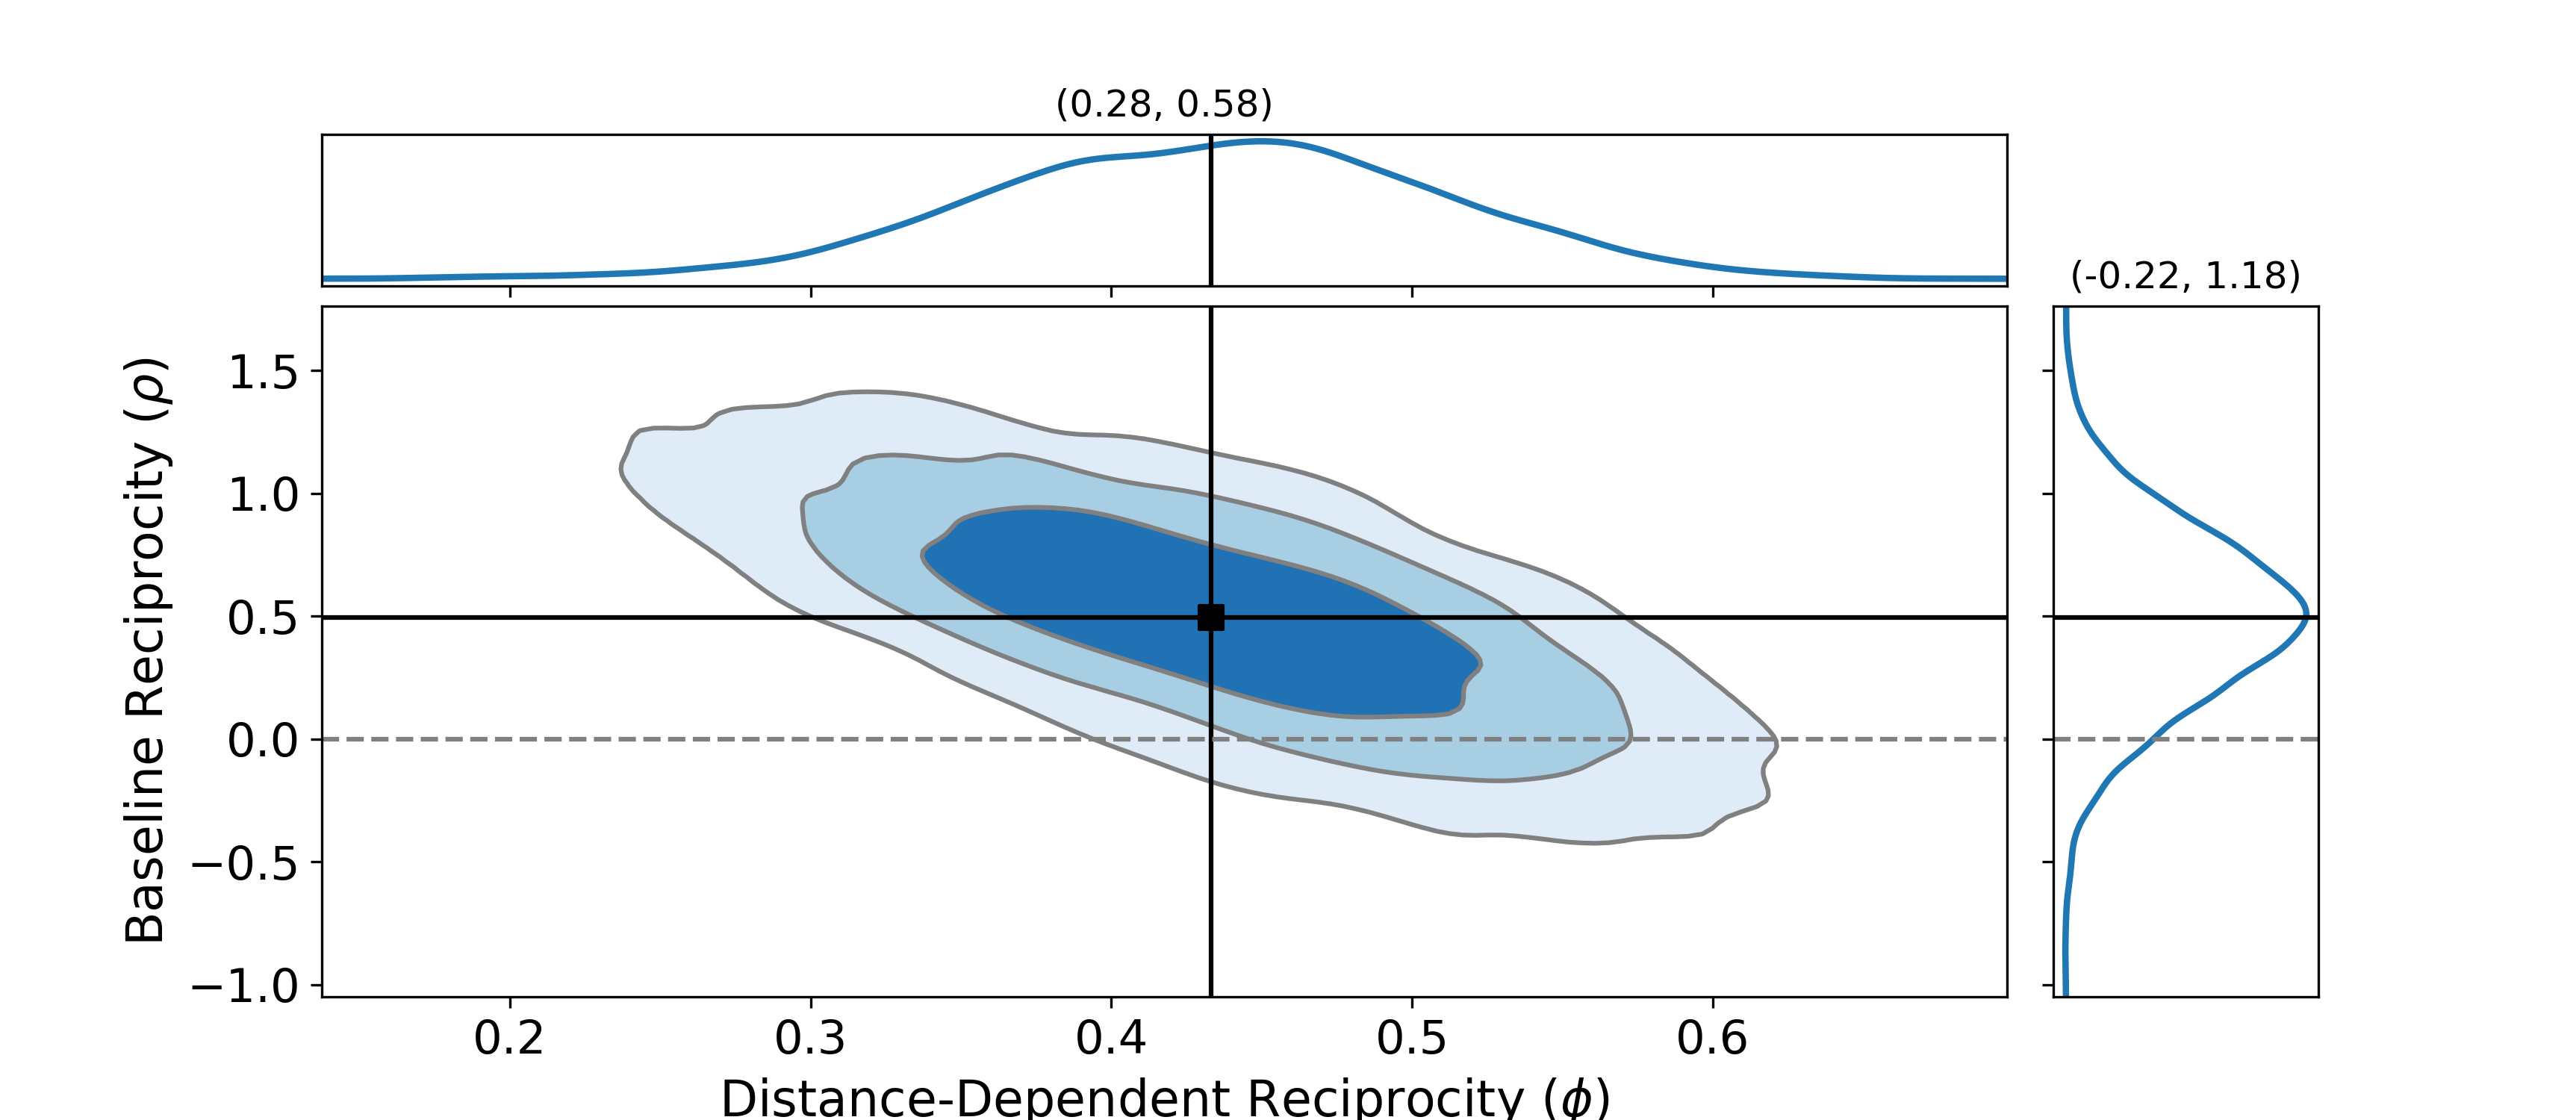

In [8]:
import arviz as az

ax = az.plot_pair(
    {r"$\phi$": model_dis.samples_['dist_coef'][None, ...],
     r"$\rho$": model_dis.samples_['recip_coef'][None, ...]},
    var_names=[r"$\phi$", r"$\rho$"],
    kind="kde",
    kde_kwargs={"hdi_probs": [0.5, 0.8, 0.95], "contourf_kwargs": {"cmap": "Blues"}},
    marginals=True,
    point_estimate="mean",
    figsize=(11.5, 5),
)
ax[1,0].set_xlabel(r"Distance-Dependent Reciprocity ($\phi$)", fontsize=16)
ax[1,0].set_ylabel(r"Baseline Reciprocity ($\rho$)", fontsize=16)
ax[1,0].tick_params(labelsize=15)

phi = model_dis.samples_['dist_coef']
rho = model_dis.samples_['recip_coef']
phi_ci = np.quantile(phi, q=[0.025, 0.975])
rho_ci = np.quantile(rho, q=[0.025, 0.975])
ax[0, 0].set_title(f"({phi_ci[0]:.2f}, {phi_ci[1]:.2f})")
ax[1, 1].set_title(f"({rho_ci[0]:.2f}, {rho_ci[1]:.2f})")

#ax[1,0].axvline(0, linestyle='--', color='gray')
ax[1,0].axhline(0, linestyle='--', color='gray')
#ax[0, 0].axvline(0, linestyle='--', color='gray')
ax[1, 1].axhline(0, linestyle='--', color='gray')

plt.savefig('/Users/joshua/myworkspace/reciprocity-lsm/images/consult_recip_ci2.png', dpi=600, bbox_inches='tight')


<IPython.core.display.Javascript object>


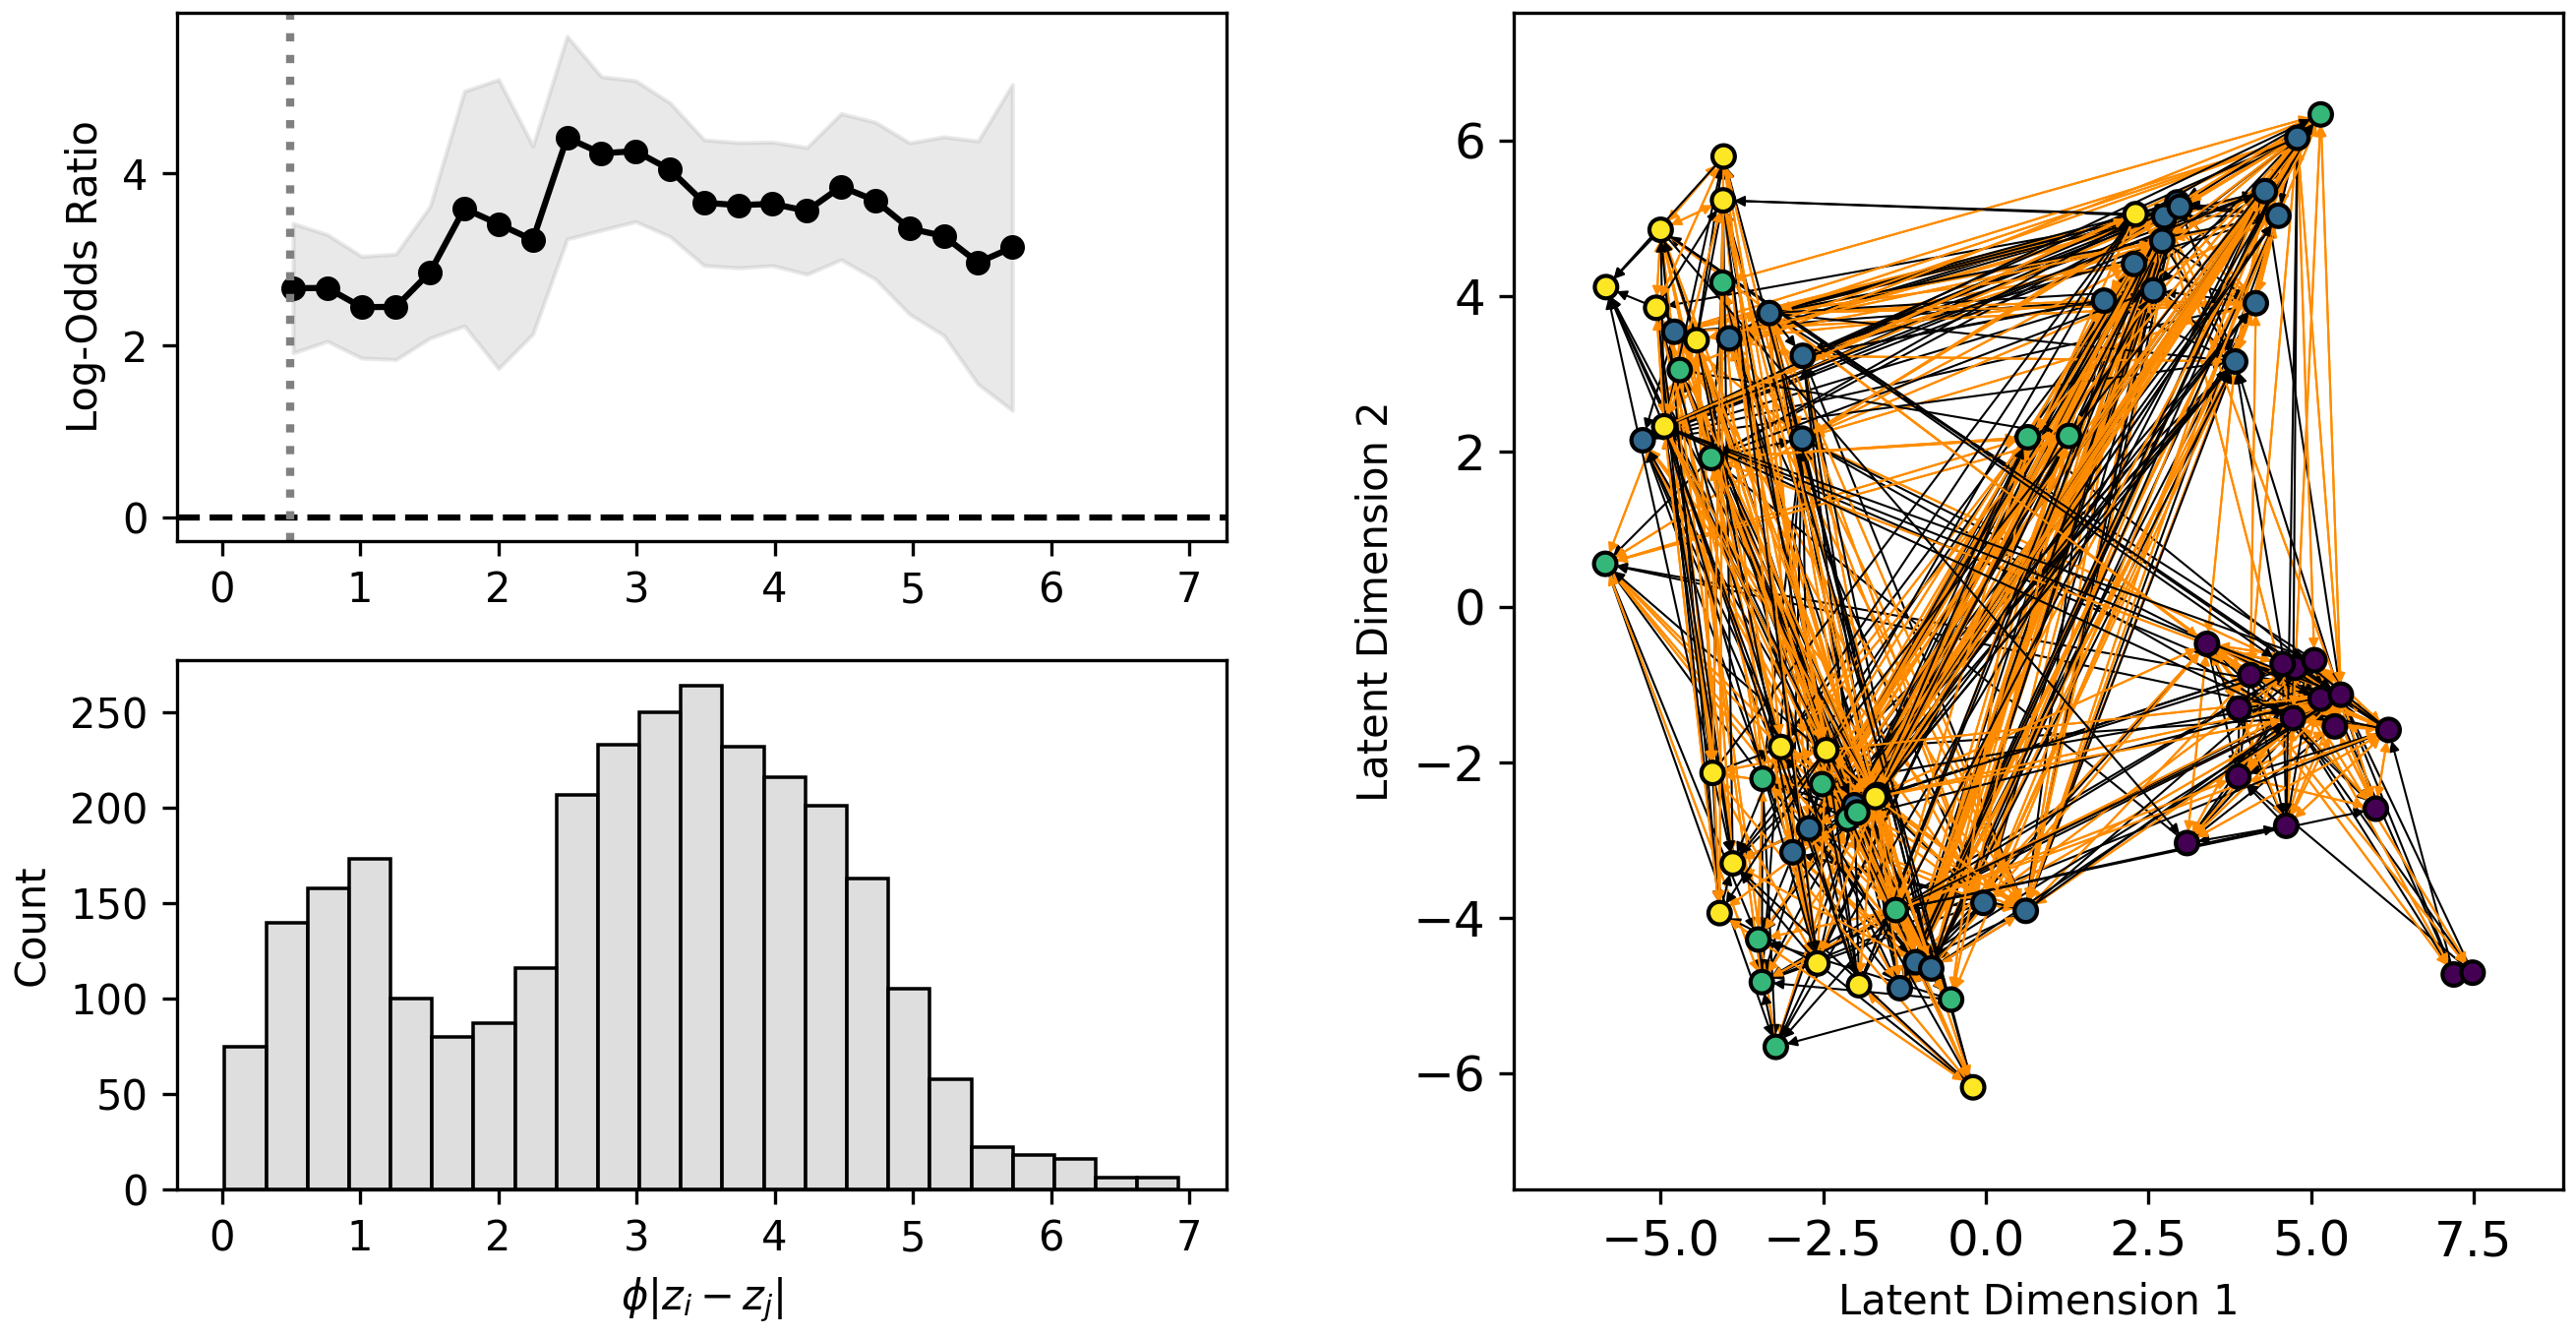

/var/folders/v3/2j2q_5r946l7qp1c47w5x7lc0000gn/T/ipykernel_71564/2632261708.py:14: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(pairwise_distance(model_dis.Z_))


In [4]:
from rlsm.rlsm import pairwise_distance
from rlsm.network_utils import adjacency_to_dyads, dyads_to_multinomial
import networkx as nx
from sklearn.cluster import KMeans

ax = plt.figure(constrained_layout=True, figsize=(8,4)).subplot_mosaic(
    """
    AABB
    CCBB
    """,
    gridspec_kw={'wspace': 0.2}
)

D = np.sqrt(pairwise_distance(model_dis.Z_))
d = np.abs(model_dis.samples_['dist_coef'].mean())  * adjacency_to_dyads(D, n=D.shape[0])[:, 0]
dyads = adjacency_to_dyads(Y, n=D.shape[0])

res = []
res_se = []
#qs = np.linspace(d.min(), d.max(), 15)
qs = np.quantile(d, q=np.linspace(0, 1, 100))
dist = []
prods = []
diff = np.diff(qs)[0] 

start = d.min()
step = model_dis.recip_coef_
while start < d.max():
    end = start + step
    a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= start, d <= end))[0]])
    #print(start, end)
    
#for i in range(1, qs.shape[0]-1):
#    #a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= qs[i] - diff, d <= qs[i] + diff))[0]])
#    print(qs[i] -diff, qs[i] + diff)
#    a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= qs[i-1], d <= qs[i]))[0]])
#    if i == 0:
#        a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= qs[i], d <= qs[i+1]))[0]])
        
    tots = a.sum(axis=0) 
    prods.append(tots[1] * tots[2])
    #tots += 0.5
    #rint(tots)
    gamma = (tots[0] * tots[-1]) / (tots[1] * tots[2]) 
    #print(tots)
    if np.prod(tots) > 0:
        res.append(np.log(gamma))
        res_se.append(np.sqrt(np.sum(1/tots)))
        dist.append(end)
        
    start += step * 0.5

sns.histplot(d, color='lightgray', edgecolor='k', ax=ax['C'])
#ax['C'].hist(d, bins=30, color='lightgray', edgecolor='k')
ax['A'].plot(np.asarray(dist), res, 'ko-', markersize=5)
ax['A'].set_ylabel('Log-Odds Ratio')
ax['C'].set_ylabel('Count')
ax['C'].set_xlabel(r'$\phi |z_i - z_j|$')
ax['A'].axhline(0., color='k', linestyle='--')
ses = 1.96 * np.asarray(res_se)
res = np.asarray(res)
ax['A'].axvline(model_dis.recip_coef_, linestyle=':', color='gray', lw=2)
ax['A'].fill_between(np.asarray(dist), res + ses, res - ses, color='darkgray', alpha=0.25)

#kmeans = KMeans(n_clusters=4).fit(model.Z_[:, :2])

g = nx.from_numpy_array(Y, create_using=nx.DiGraph)
pos = {k : model_dis.Z_[k, :2] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'k' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color=locations,
                 #node_color='steelblue', 
                 edgecolors='k',
                 edge_color=ecolor, width=0.5, with_labels=False,
                 arrowsize=5,
                 node_size=30, ax=ax['B'])
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].set_ylabel('Latent Dimension 2')
ax['B'].set_xlabel('Latent Dimension 1')
ax['A'].sharex(ax['C'])

#plt.savefig('/Users/joshua/myworkspace/reciprocity-lsm/images/consult_ls.png', dpi=600, bbox_inches='tight')

<IPython.core.display.Javascript object>


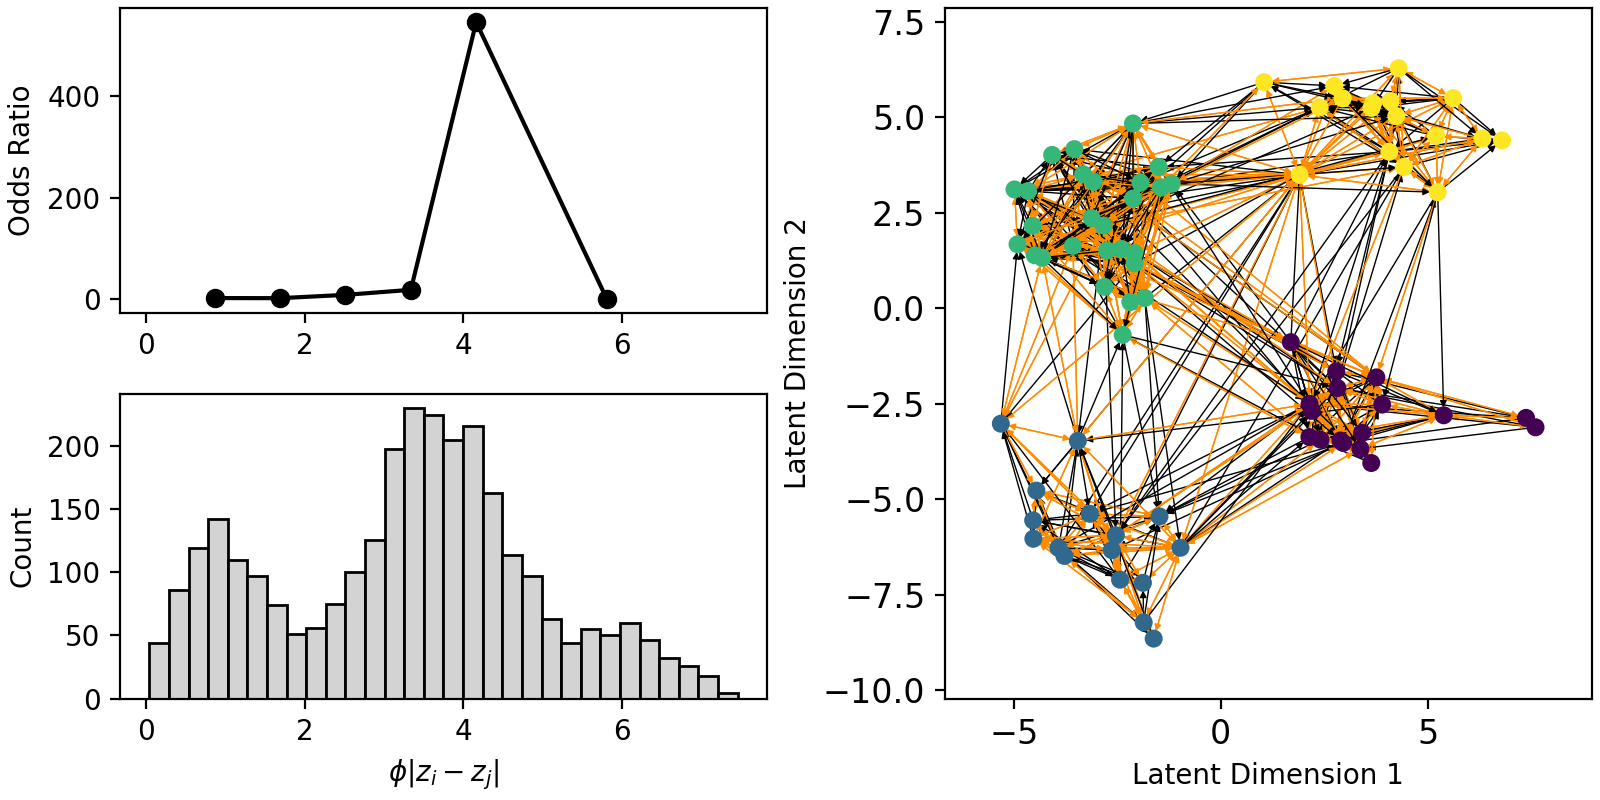

/var/folders/v3/2j2q_5r946l7qp1c47w5x7lc0000gn/T/ipykernel_12555/4219014761.py:13: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(pairwise_distance(model.Z_))


In [16]:
from rlsm.rlsm import pairwise_distance
from rlsm.network_utils import adjacency_to_dyads, dyads_to_multinomial
import networkx as nx
from sklearn.cluster import KMeans

ax = plt.figure(constrained_layout=True, figsize=(8,4)).subplot_mosaic(
    """
    AABB
    CCBB
    """
)

D = np.sqrt(pairwise_distance(model.Z_))
d = np.abs(model.samples_['dist_coef'].mean())  * adjacency_to_dyads(D, n=D.shape[0])[:, 0]
dyads = adjacency_to_dyads(Y, n=D.shape[0])

res = []
qs = np.linspace(d.min(), d.max(), 10)
#qs = np.quantile(d, q=np.linspace(0, 1, 10))
dist = []
for i in range(qs.shape[0]-1):
    a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= qs[i], d <= qs[i+1]))[0]])
    tots = a.sum(axis=0) 
    gamma = (tots[0] * tots[-1]) / (tots[1] * tots[2]) 
    if tots[1] * tots[2] > 0:
        res.append(gamma)
        dist.append(qs[i+1])

ax['C'].hist(d, bins=30, color='lightgray', edgecolor='k')
ax['A'].plot(np.asarray(dist), res, 'ko-')
ax['A'].set_ylabel('Odds Ratio')
ax['C'].set_ylabel('Count')
ax['C'].set_xlabel(r'$\phi |z_i - z_j|$')

kmeans = KMeans(n_clusters=4).fit(model.Z_[:, :2])

g = nx.from_numpy_array(Y, create_using=nx.DiGraph)
pos = {k : model.Z_[k, :2] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'k' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color=kmeans.labels_,
                 edge_color=ecolor, width=0.5, with_labels=False,
                 arrowsize=5,
                 node_size=30, ax=ax['B'])
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].set_ylabel('Latent Dimension 2')
ax['B'].set_xlabel('Latent Dimension 1')
ax['A'].sharex(ax['C'])

<IPython.core.display.Javascript object>


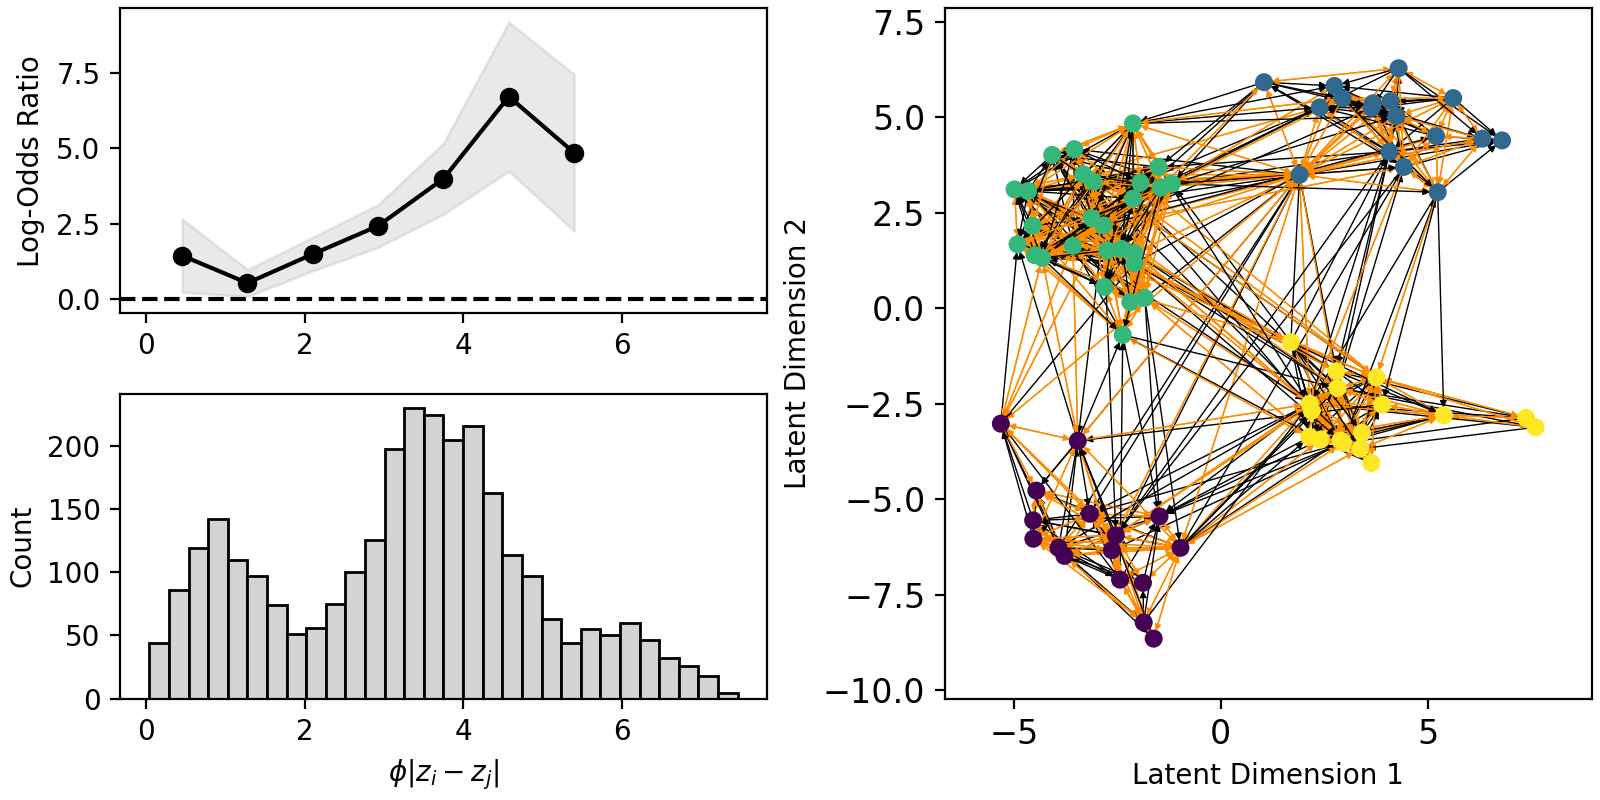

/var/folders/v3/2j2q_5r946l7qp1c47w5x7lc0000gn/T/ipykernel_12555/337811784.py:13: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(pairwise_distance(model.Z_))


In [18]:
from rlsm.rlsm import pairwise_distance
from rlsm.network_utils import adjacency_to_dyads, dyads_to_multinomial
import networkx as nx
from sklearn.cluster import KMeans

ax = plt.figure(constrained_layout=True, figsize=(8,4)).subplot_mosaic(
    """
    AABB
    CCBB
    """
)

D = np.sqrt(pairwise_distance(model.Z_))
d = np.abs(model.samples_['dist_coef'].mean())  * adjacency_to_dyads(D, n=D.shape[0])[:, 0]
dyads = adjacency_to_dyads(Y, n=D.shape[0])

res = []
res_se = []
qs = np.linspace(d.min(), d.max(), 10)
#qs = np.quantile(d, q=np.linspace(0, 1, 10))
dist = []
diff = np.diff(qs)[0] * 0.5
for i in range(qs.shape[0]-1):
    a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= qs[i] - diff, d <= qs[i] + diff))[0]])
    tots = a.sum(axis=0) 
    gamma = (tots[0] * tots[-1]) / (tots[1] * tots[2]) 
    if np.prod(tots) > 0:#tots[1] * tots[2] > 0:
        res.append(np.log(gamma))
        res_se.append(np.sqrt(np.sum(1/tots)))
        dist.append(qs[i] + diff)

ax['C'].hist(d, bins=30, color='lightgray', edgecolor='k')
ax['A'].plot(np.asarray(dist), res, 'ko-')
ax['A'].set_ylabel('Log-Odds Ratio')
ax['C'].set_ylabel('Count')
ax['C'].set_xlabel(r'$\phi |z_i - z_j|$')
ax['A'].axhline(0., color='k', linestyle='--')
ses = 1.96 * np.asarray(res_se)
res = np.asarray(res)
ax['A'].fill_between(np.asarray(dist), res + ses, res - ses, color='darkgray', alpha=0.25)

kmeans = KMeans(n_clusters=4).fit(model.Z_[:, :2])

g = nx.from_numpy_array(Y, create_using=nx.DiGraph)
pos = {k : model.Z_[k, :2] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'k' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color=kmeans.labels_,
                 edge_color=ecolor, width=0.5, with_labels=False,
                 arrowsize=5,
                 node_size=30, ax=ax['B'])
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].set_ylabel('Latent Dimension 2')
ax['B'].set_xlabel('Latent Dimension 1')
ax['A'].sharex(ax['C'])

<IPython.core.display.Javascript object>


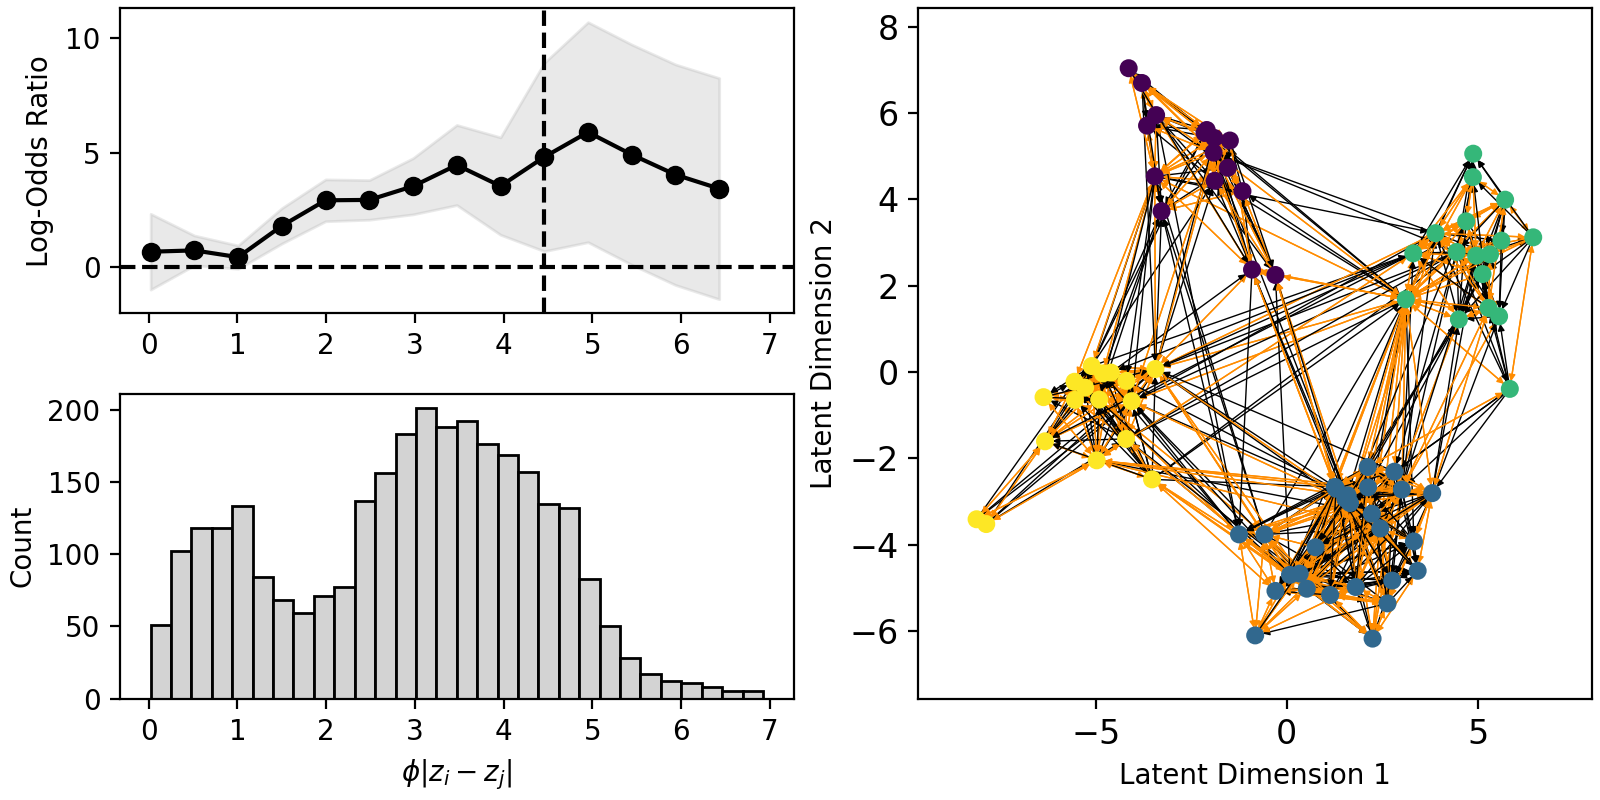

/var/folders/v3/2j2q_5r946l7qp1c47w5x7lc0000gn/T/ipykernel_50438/3562899181.py:13: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(pairwise_distance(model.Z_))


In [49]:
from rlsm.rlsm import pairwise_distance
from rlsm.network_utils import adjacency_to_dyads, dyads_to_multinomial
import networkx as nx
from sklearn.cluster import KMeans

ax = plt.figure(constrained_layout=True, figsize=(8,4)).subplot_mosaic(
    """
    AABB
    CCBB
    """
)

D = np.sqrt(pairwise_distance(model.Z_))
d = np.abs(model.samples_['dist_coef'].mean())  * adjacency_to_dyads(D, n=D.shape[0])[:, 0]
dyads = adjacency_to_dyads(Y, n=D.shape[0])

res = []
res_se = []
qs = np.linspace(d.min(), d.max(), 15)
#qs = np.quantile(d, q=np.linspace(0, 1, 20))
dist = []
prods = []
diff = np.diff(qs)[0] * 0.5
for i in range(qs.shape[0]-1):
    a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= qs[i] - diff, d <= qs[i] + diff))[0]])
    tots = a.sum(axis=0) 
    prods.append(np.prod(tots))
    tots += 0.5
    gamma = (tots[0] * tots[-1]) / (tots[1] * tots[2]) 
    if np.prod(tots) > 0:#tots[1] * tots[2] > 0:
        res.append(np.log(gamma))
        res_se.append(np.sqrt(np.sum(1/tots)))
        dist.append(qs[i])

ax['C'].hist(d, bins=30, color='lightgray', edgecolor='k')
ax['A'].plot(np.asarray(dist), res, 'ko-')
ax['A'].set_ylabel('Log-Odds Ratio')
ax['C'].set_ylabel('Count')
ax['C'].set_xlabel(r'$\phi |z_i - z_j|$')
ax['A'].axhline(0., color='k', linestyle='--')
ids = np.where(np.asarray(prods) == 0)[0][0]
ax['A'].axvline(dist[ids], color='k', linestyle='--')
ses = 1.96 * np.asarray(res_se)
res = np.asarray(res)
ax['A'].fill_between(np.asarray(dist), res + ses, res - ses, color='darkgray', alpha=0.25)

kmeans = KMeans(n_clusters=4).fit(model.Z_[:, :2])

g = nx.from_numpy_array(Y, create_using=nx.DiGraph)
pos = {k : model.Z_[k, :2] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'k' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color=kmeans.labels_,
                 edge_color=ecolor, width=0.5, with_labels=False,
                 arrowsize=5,
                 node_size=30, ax=ax['B'])
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].set_ylabel('Latent Dimension 2')
ax['B'].set_xlabel('Latent Dimension 1')
ax['A'].sharex(ax['C'])

The reference value is outside of the posterior. This translate into infinite support for H1, which is most likely an overstatement.


<IPython.core.display.Javascript object>


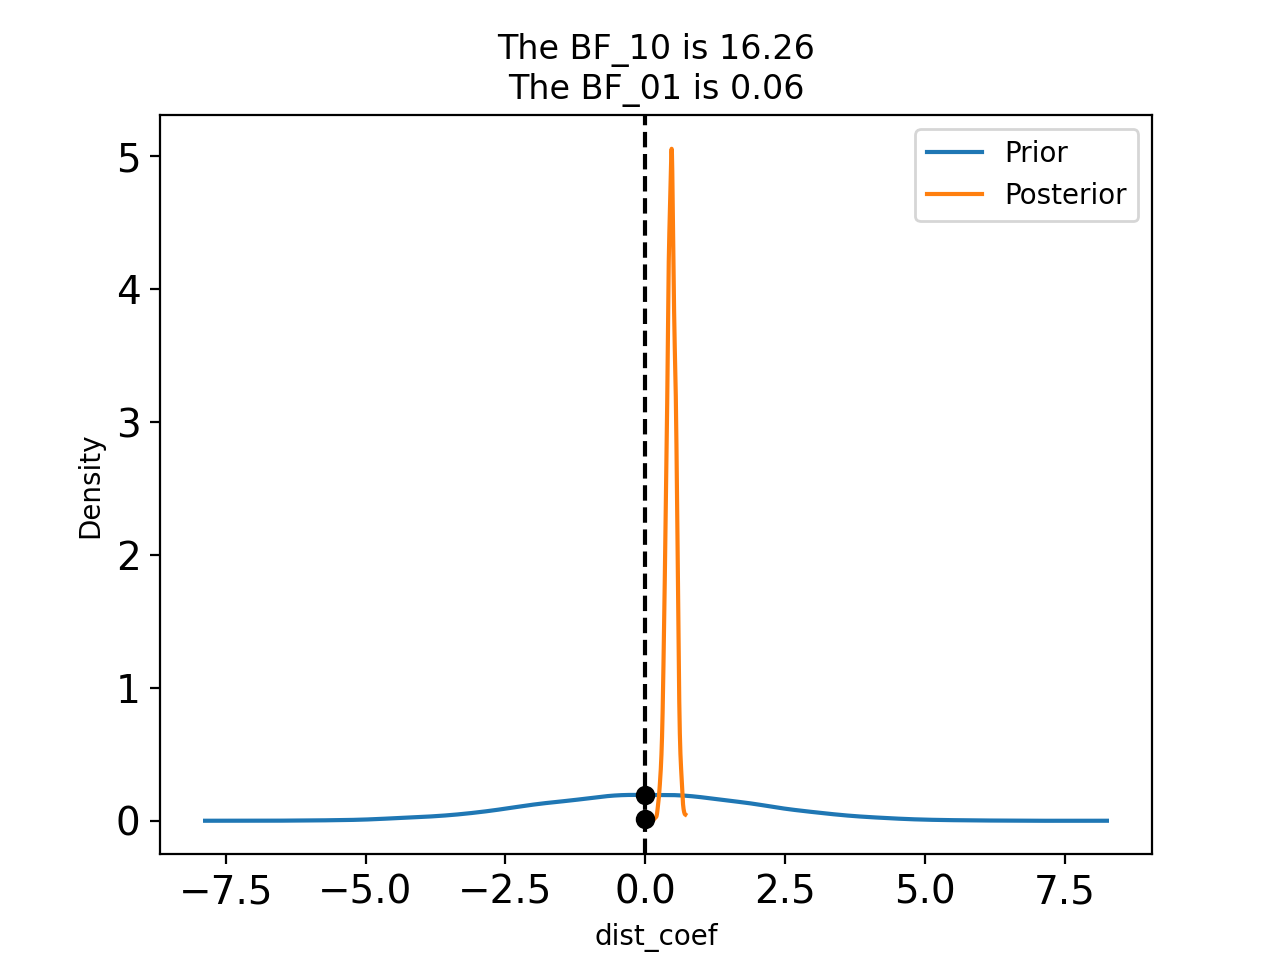

({'BF10': 16.255955328529698, 'BF01': 0.06151591707716922},
 <Axes: title={'center': 'The BF_10 is 16.26\nThe BF_01 is 0.06'}, xlabel='dist_coef', ylabel='Density'>)

# No Reciprocity

In [32]:
model_no = ReciprocityLSM(n_features=2, reciprocity_type='none', random_state=142)
model_no.sample(Y, n_warmup=2500, n_samples=5000)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7500/7500 [18:13<00:00,  6.86it/s, 127 steps of size 3.81e-02. acc. prob=0.78]


In [34]:
model_no.print_summary()

AUC: 0.972, AIC: 2623.271, WAIC: 2472.235

                mean       std    median      2.5%     97.5%     n_eff     r_hat
     r_var      0.95      0.24      0.93      0.53      1.44    730.47      1.00
     s_var      2.43      0.55      2.37      1.47      3.55    656.91      1.00
   sr_corr      0.69      0.17      0.71      0.38      1.00    921.98      1.00
     z_var     18.11      2.55     17.89     13.64     23.35   1922.10      1.00

Number of divergences: 132


In [36]:
joblib.dump(model_no, open('consult_no.pkl', 'wb'))

In [33]:
model_con = ReciprocityLSM(n_features=2, reciprocity_type='constant', random_state=142)
model_con.sample(Y, n_warmup=2500, n_samples=5000)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7500/7500 [18:44<00:00,  6.67it/s, 127 steps of size 3.83e-02. acc. prob=0.82]


In [35]:
model_con.print_summary()

AUC: 0.971, AIC: 2551.631, WAIC: 2415.971

                  mean       std    median      2.5%     97.5%     n_eff     r_hat
       r_var      0.78      0.20      0.75      0.40      1.17   1967.65      1.00
  recip_coef      1.90      0.21      1.91      1.50      2.33   3832.66      1.00
       s_var      2.41      0.55      2.34      1.45      3.53   1223.40      1.00
     sr_corr     -0.03      0.18     -0.03     -0.38      0.33   1480.15      1.00
       z_var     11.75      1.80     11.60      8.47     15.28   1594.52      1.00

Number of divergences: 111


In [37]:
joblib.dump(model_con, open('consult_con.pkl', 'wb'))

# Goodness of Fit

In [7]:
from rlsm.gof import reciprocity

res_dis = model_dis.posterior_predictive(reciprocity)
res_con = model_con.posterior_predictive(reciprocity)
res_no = model_no.posterior_predictive(reciprocity)

NameError: name 'model_con' is not defined

In [6]:
res_dis.shape

(5000,)